In [2]:
import MDAnalysis as mda
from tqdm import trange, tqdm
import numpy as np
import matplotlib.pyplot as plt

/home/f0042vb/anaconda3/envs/py310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


This is a 5 ns npt simulation of $\beta$-cyclodextrin and adamantane in a 6 * 6 * 6 nm box with 6966 water molecules. We want to see whether this complex is stable enough and what is the orientation of adamantane within the pore and prepared for alchemical free energy calculation.

The initial configuration is generated from a crystal structure (CCDC2053567). CHARMM36 was used as force field. Tip3p was used as water model.

<img src="./figure 1.png" alt="image1" width="20%" height="auto">

100%|██████████| 501/501 [00:00<00:00, 1884.45it/s]


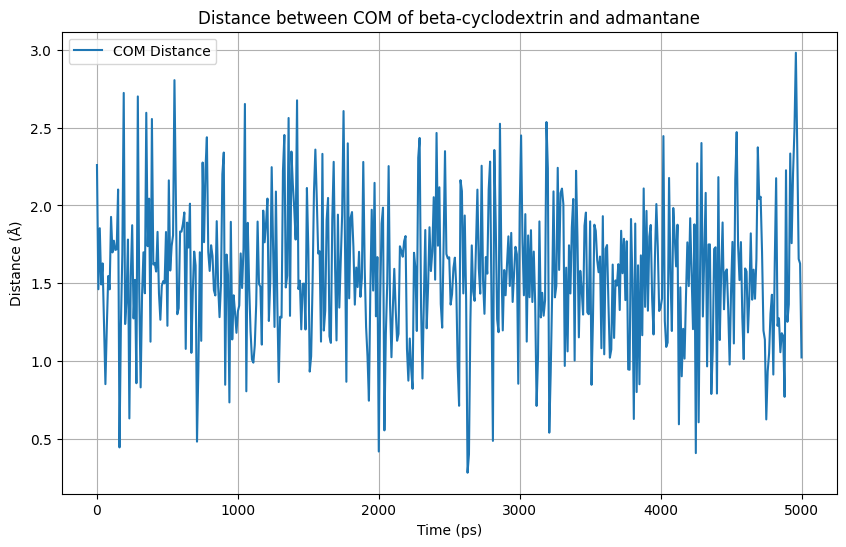

In [4]:
tpr = f"/home/f0042vb/CHEM101.6/final_proj/cd-ad/complex/npt.tpr"
xtc = f"/home/f0042vb/CHEM101.6/final_proj/cd-ad/complex/npt_nojump.xtc"

u = mda.Universe(tpr,xtc)

beta_cyclodextrin = u.select_atoms("resname CD_")
adamantane = u.select_atoms("resname ADH")

distances = []
times = []


def calculate_distance_pbc(delta, L):

    delta = np.abs(delta)
    delta = np.where(delta > 0.5 * L, L - delta, delta)
    distance = np.sqrt((delta**2).sum(axis=-1))
    return distance



for ts in tqdm(u.trajectory):

    com_beta_cyclodextrin = beta_cyclodextrin.center_of_mass()
    com_adamantane = adamantane.center_of_mass()
    box = ts.dimensions[:3]




    distance = calculate_distance_pbc(com_beta_cyclodextrin - com_adamantane,box)


    distances.append(distance)
    times.append(ts.time)


distances = np.array(distances)
times = np.array(times)


plt.figure(figsize=(10, 6))
plt.plot(times, distances, label='COM Distance')
plt.xlabel('Time (ps)')
plt.ylabel('Distance (Å)')
plt.title('Distance between COM of beta-cyclodextrin and admantane')
plt.legend()
plt.grid(True)
plt.show()

This result indicated that adamantane didn't leave the pocket.

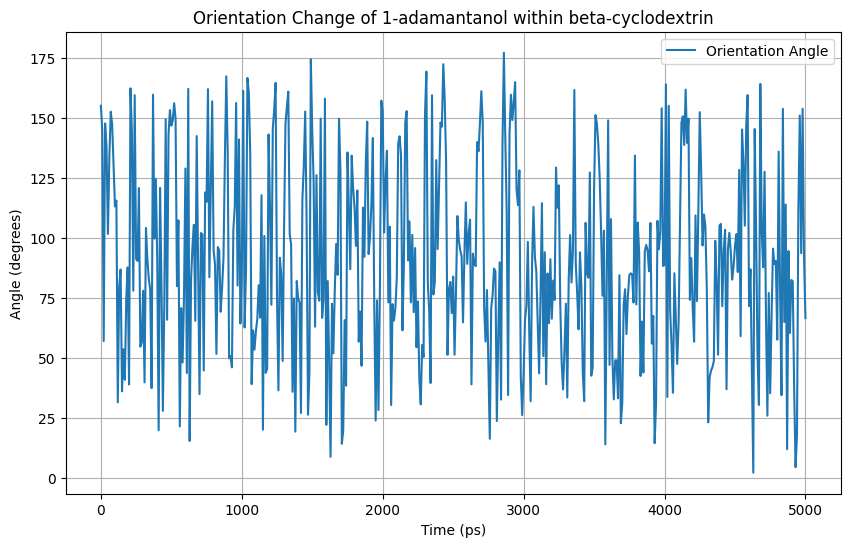

In [20]:
# Example: vector in 1-adamantane
guest_atom1 = adamantane[1]
guest_atom2 = adamantane[2]


angles = []
times = []

def select_str(molecule,atom_names):
    selection_str = " or ".join(f"name {name}" for name in atom_names)
    return u.select_atoms(selection_str)

def get_cd_atom(cd):
    small = ["C122","C109","C96","C83","C70","C57","C135"]
    large = ["O4","O6","O14","012","O20","022","O28","O30","O36","O38","O44","O46","O52","O54"]
    small_center = select_str(cd,small).center_of_mass()
    large_center = select_str(cd,large).center_of_mass()
    return large_center-small_center


def calculate_angle(v1, v2):
    cos_theta = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
    angle = np.arccos(np.clip(cos_theta, -1.0, 1.0))
    return np.degrees(angle)


for ts in u.trajectory:

    vector_cd = get_cd_atom(beta_cyclodextrin)
    vector_guest = guest_atom2.position - guest_atom1.position


    angle = calculate_angle(vector_cd, vector_guest)


    angles.append(angle)
    times.append(ts.time)


angles = np.array(angles)
times = np.array(times)


plt.figure(figsize=(10, 6))
plt.plot(times, angles, label='Orientation Angle')
plt.xlabel('Time (ps)')
plt.ylabel('Angle (degrees)')
plt.title('Orientation Change of 1-adamantanol within beta-cyclodextrin')
plt.legend()
plt.grid(True)
plt.show()
 

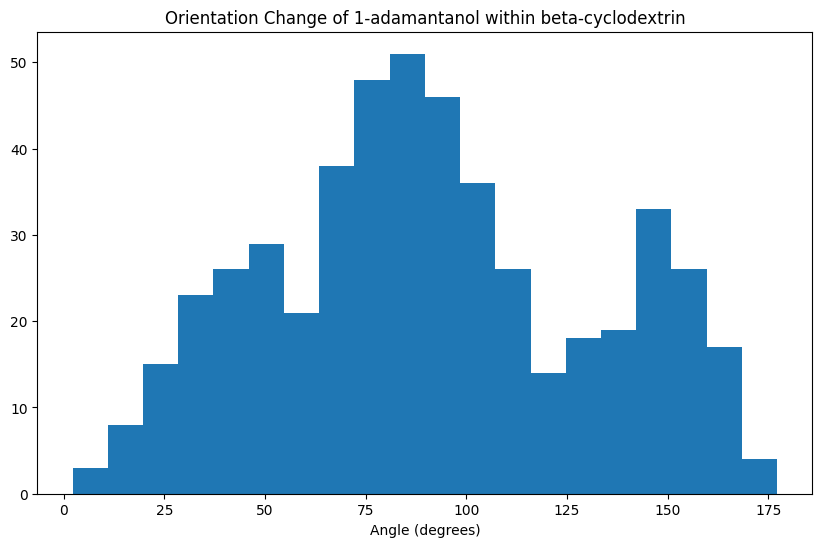

In [23]:
plt.figure(figsize=(10, 6))
plt.hist(angles,bins=20)
plt.title('Orientation Change of 1-adamantanol within beta-cyclodextrin')
plt.xlabel('Angle (degrees)')
plt.show()


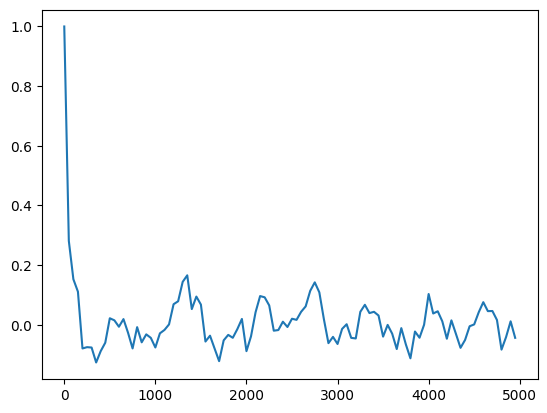

In [28]:
#autocorrelation time of the adamantane in the pore

def model_func(x, a, b):
    return a*np.exp(-b * x)

def autocorr1(x,lags):
    '''numpy.corrcoef, partial'''
    corr=[1. if l==0 else np.corrcoef(x[l:],x[:-l])[0][1] for l in lags]
    return np.array(corr)

plt.plot(np.arange(100)*50,autocorr1(angles, range(100)))

This preliminary results indicates that there's a preferred binding orientation, but it changed relatively fast.